# Correlations in Two Photon Data

In this notebook, we'll explore correlations in single cell two-photon imaging data. In neuroscience, correlation is taken into acount between activity of different brain areas and between activity of individual neurons. It is widley believed that neurons that wire together, fire together, therfore spike correlations may reveal functional relations between neurons and explain how neurons encode information. Before we begin, we will ensure that the Allen SDK is intalled, as well as the other necessary toolkits. 

In [1]:
# This will ensure that the AllenSDK is installed.
# If not, it will install it for you.
try:
    import allensdk
    if allensdk.__version__ == '2.11.2':
        print('allensdk already installed.')
    else:
        print('incompatible version of allensdk installed')
except ImportError as e:
    !pip install allensdk

allensdk already installed.


In [2]:
# Import toolboxes
import allensdk.brain_observatory.stimulus_info as stim_info
from allensdk.core.brain_observatory_cache import BrainObservatoryCache
import numpy as np
import scipy as sp
import warnings
warnings.filterwarnings('ignore')

# Plotting setup
%config InlineBackend.figure_format = 'retina' # Improve the resolution of our plots!
%matplotlib inline
import matplotlib.pyplot as plt
print('Packages imported.')

Packages imported.


## Accessing Signal Correlation 

We will be using the Two Photon Imaging Data from the Allen SDK that we have used in the previous sections. Like before, we will start by assigning an experiment container and stimulus that we will use to download our desired experiments using `get_ophys_experiments()` to return an experiment id. 

The `get_ophys_experiment_analysis()` method returns a data accessor object that we will use to create our signal correlation object. This object will contain many precomputed metrics of the neuron, one being the signal correlation between neurons. The signal correlations can be accessed through the `signal_correltation` attriubute of our data accessor object. 

In [3]:
# Create an instance of the Brain Observatory cache
boc = BrainObservatoryCache(manifest_file='manifest.json')

# Assign container ID
exp_container_id = 627823571
stim = 'natural_scenes'

# Get experiments for our container id and stimuli of interest
experiments = boc.get_ophys_experiments(experiment_container_ids = [exp_container_id],
                                     stimuli = [stim])

# Assign the experiment id 
experiment_id = experiments[0]['id']

# Import the natural scenes analysis
ns = boc.get_ophys_experiment_analysis(ophys_experiment_id= experiment_id, 
                                       stimulus_type= stim)

# Get the signal correlation
sc = ns.signal_correlation

print('Signal correlation acquired.')

Signal correlation acquired.


Lets gets some information on our signal correlation object by returning the shape and its values. 

In [4]:
print(sc.shape)
print('\n Signal Correlation Values:')
print(sc)

(122, 122)

 Signal Correlation Values:
[[1.         0.14323458 0.17951859 ... 0.01880074 0.23897593 0.66786783]
 [0.14323458 1.         0.23507335 ... 0.01021934 0.15987039 0.1993377 ]
 [0.17951859 0.23507335 1.         ... 0.30795471 0.2214713  0.20853155]
 ...
 [0.01880074 0.01021934 0.30795471 ... 1.         0.31723401 0.1081826 ]
 [0.23897593 0.15987039 0.2214713  ... 0.31723401 1.         0.37313061]
 [0.66786783 0.1993377  0.20853155 ... 0.1081826  0.37313061 1.        ]]


By looking at the shape of our signal correlation object, we can see that there are 122 cells in our data. When we print out the signal correlation object, we can see that it is multi-dimentional because each cell's signal correlation is computed across every other cell in our data.

## Plotting 

We can now plot a heatmap of the signal correltations between neurons. The heatmap will plot our 122 neurons against each other to determine functional connectivity. The idea behind this is that if brain areas are active together, they may be coming together to accomplish the same task in the brain, forming neuronal networks. 

Text(0, 0.5, 'Cell #')

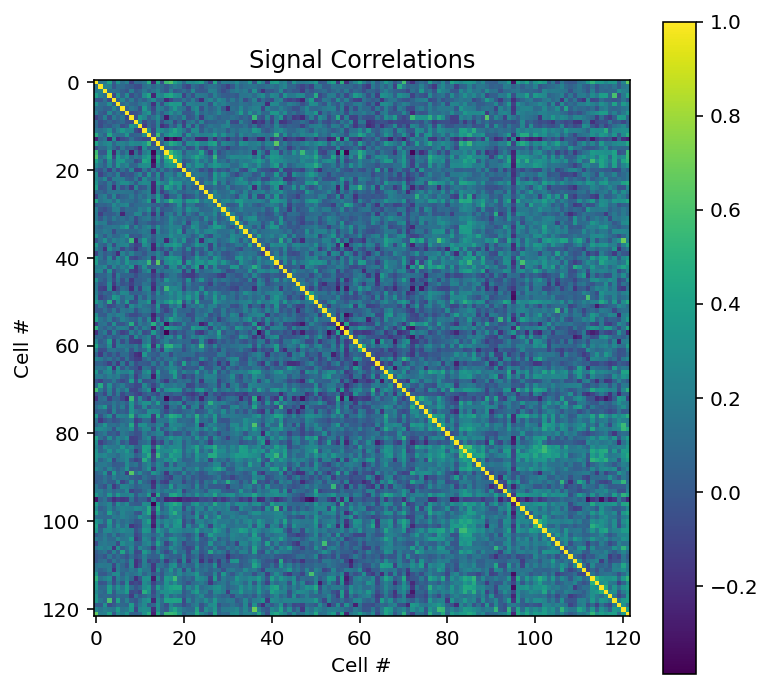

In [5]:
plt.figure(figsize = [6, 6])

plt.imshow(sc)
plt.colorbar()
plt.title('Signal Correlations')
plt.xlabel('Cell #')
plt.ylabel('Cell #')

Neurons that are closer together in space tend to have stronger correlations. For this reason it is a good idea to calculate the distance between the neurons. To remind ourselves of what our fluroecent image looks like, the maximum projection of our cells is displayed below. 

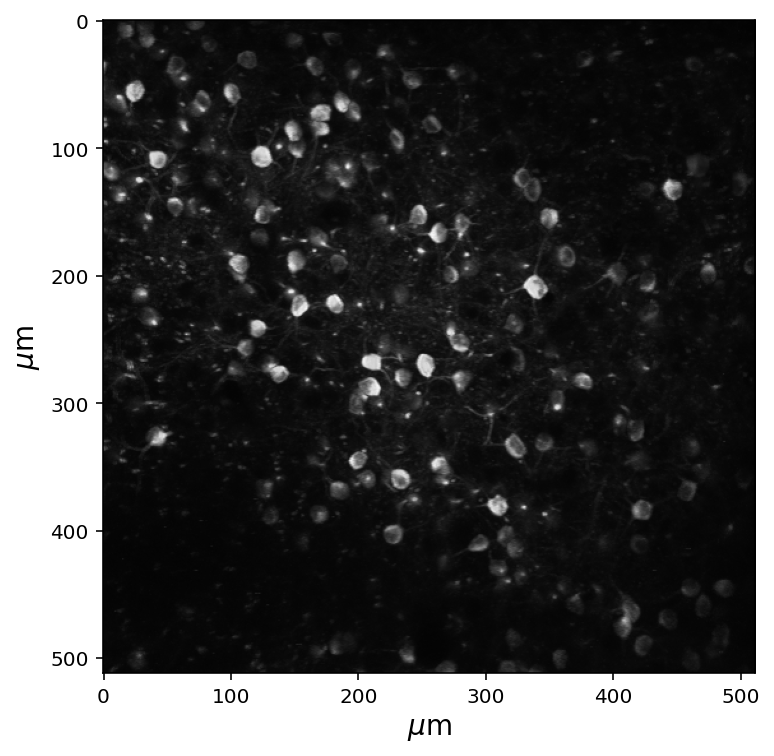

In [6]:
# Get the max projection of the data and show it
fig = plt.figure(figsize=(6,6))
data_set = boc.get_ophys_experiment_data(ophys_experiment_id= experiment_id)
max_proj = data_set.get_max_projection()
plt.imshow(max_proj, cmap='gray')

# Add labels for microns; weird syntax below is to get the micro sign
plt.ylabel(r'$\mu$m',fontsize=14)
plt.xlabel(r'$\mu$m',fontsize=14)
plt.show()

In the block below, we'll get the regions of interest (ROIs) and then calculate the distance between these ROIs, using simple geometric distance. The `get_roi_mask_array()` method will return a NumPy array containing all the regions of interest for our experiment. All of the cells in our maximum projection image are defined as a region of interest. For a better understanding, below we will show how one region of interest corresponds to our image above.

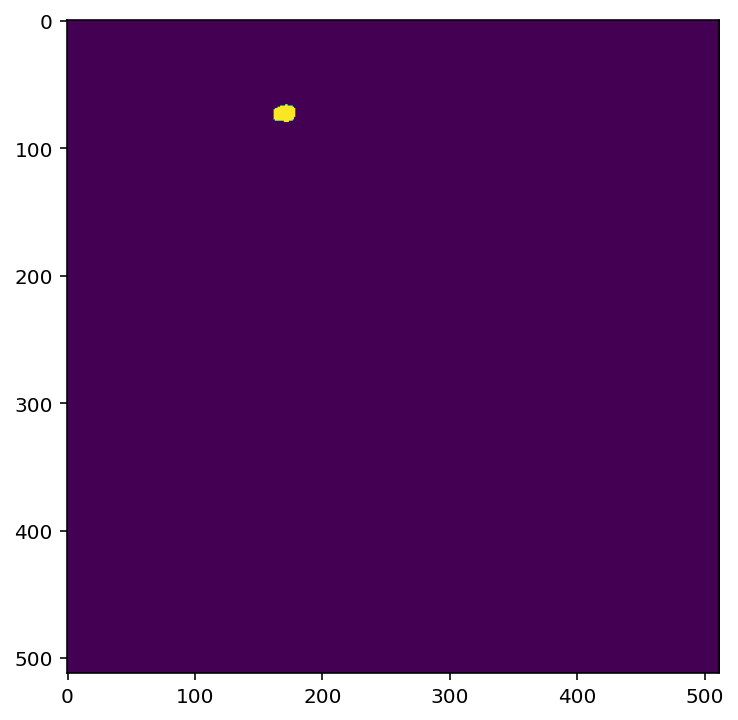

In [7]:
rois = data_set.get_roi_mask_array()
plt.figure(figsize = [6,6])
plt.imshow(rois[1])
plt.show()

This distance that we calculate will be in "pixels" of the image -- we'd need to know the size of our field of view in order to get this into actual units of distance. The plot will display how far a cell is to every other cell. 

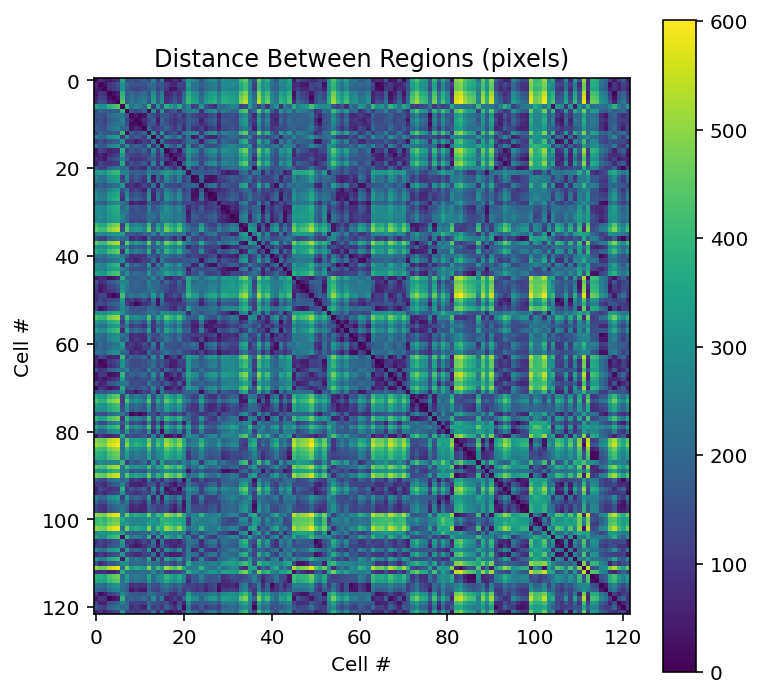

In [8]:
rois = data_set.get_roi_mask_array()

num_cells = rois.shape[0]
loc_x = np.zeros((num_cells))
loc_y = np.zeros((num_cells))

# Assign the centers of each roi
for i in range(num_cells):
    ind = np.where(rois[i])
    loc_x[i] = np.mean(ind[1])
    loc_y[i] = np.mean(ind[0])

# Calculate the distances     
distance = np.zeros((num_cells, num_cells))
for i in range(num_cells):
    for j in range(num_cells):
        distance[i, j] = np.sqrt( (loc_x[i]-loc_x[j])**2 + (loc_y[i]-loc_y[j])**2 )

# Plot the distance matrix
plt.figure(figsize = [6,6])
plt.imshow(distance, cmap='viridis', interpolation='none')
plt.title('Distance Between Regions (pixels)')
plt.xlabel("Cell #")
plt.ylabel("Cell #")
plt.colorbar()
plt.show()

Below, we'll plot the distribution of distances. Importantly, we only count each distance once, so we'll use a numpy function called <a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.triu_indices.html">triu_indices</a> to get the x and y indices of the the values. This is becasue in our matrices our symmetrical, meaning the top right triangle is identical to the bottom left triangle. `triu_indices()` will return a pair of indices for each location on our matrix , thus creating a vector that contains all the values in our matrix.

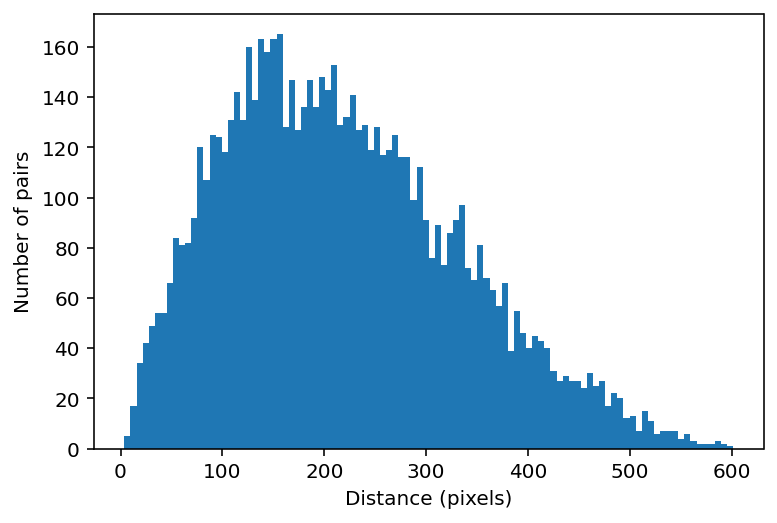

In [9]:
inds = np.triu_indices(num_cells, k=1)
distance_vector = distance[inds[0], inds[1]]
plt.hist(distance_vector, bins=100)
plt.xlabel("Distance (pixels)")
plt.ylabel("Number of pairs")
plt.show()

We now have a matrix of the signal correlations and a matrix of the distance. Our next step is to as if these two things are correlated. To test this, we can plot a scatter plot of the distance versus the signal correlation. However, it is better to plot the `distance_vector` versus the `sc_vector`, becasue this will remove the point where the cells are plotted against themselves in our matrices (i.e the diagonal).

r_value: -0.023194    p_value: 0.046302
pearson's r: -0.023194    pearson's p: 0.046302


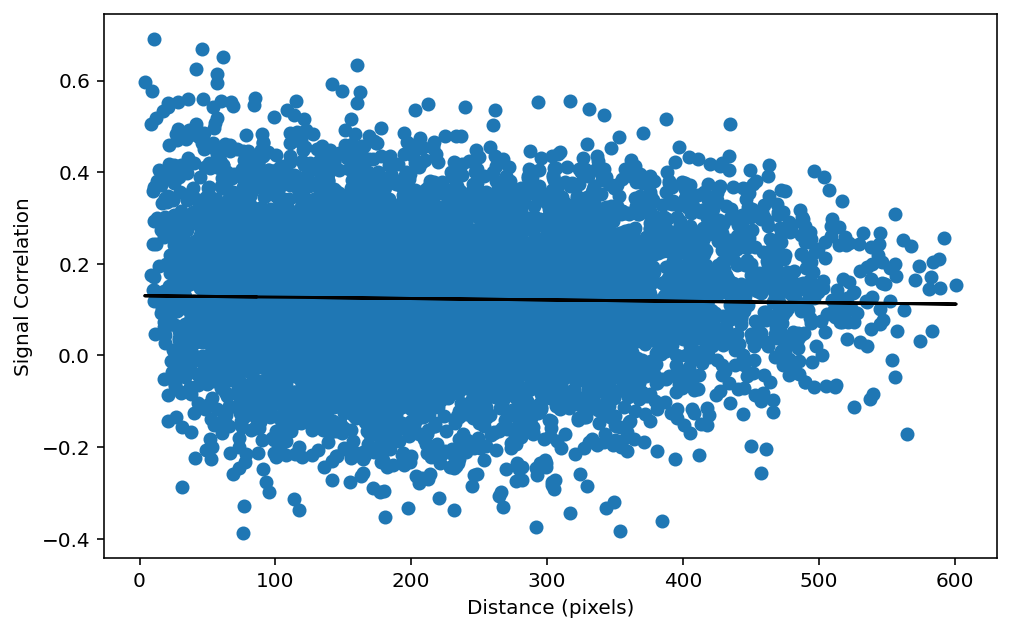

In [10]:
plt.figure(figsize=(8,5))

# Assign our signal correlation vector
sc_vector = sc[inds[0], inds[1]]

# Plot the scatter plot
plt.scatter(distance_vector, sc_vector)
plt.xlabel('Distance (pixels)')
plt.ylabel('Signal Correlation')

# Calculate the linear regression
slope, intercept, r_value, p_value, std_err = sp.stats.linregress(distance_vector, sc[inds[0], inds[1]])
plt.plot(distance_vector,intercept+slope*distance[inds[0], inds[1]],"k-")
print("r_value: %f    p_value: %f" % (r_value, p_value))

# Calculate the Pearson's correlation
pearsons_r , pearsons_p = sp.stats.pearsonr(distance_vector, sc[inds[0], inds[1]])
print("pearson's r: %f    pearson's p: %f" % (pearsons_r, pearsons_p))